# adam 옵티마이져
# 퍼셉트론과 이진 분류를 위한 지도학습 훈련 반복

In [1]:
import torch

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
LEFT_CENTER = (3,3)
RIGHT_CENTER = (3,-2)

In [4]:
# 모델정의  nn.Module 상속받아서 퍼셉트론을 구현

In [5]:
class Perceptron(nn.Module):
    '''퍼셉트론은 하나의 선형층'''
    def __init__(self, input_dim):
        '''
            매개변수 : 
                input_dim(int) : 입력 특성의 크기
        '''
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim,1)
    def forward(self, x_in):
        '''
            퍼셉트론의 전방계산
            매개변수 : x_in(torch.Tensor): 입력 데이터 텐서
                x_in.shape  는 (batch, num_features) 
            반환값 : 결과 텐서 tensor.shape(batch,)            
        '''
        return torch.sigmoid(self.fc1(x_in))
    

# 데이터 준비

In [6]:
def get_data(batch_size, left_center=LEFT_CENTER, right_center = RIGHT_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc = left_center))
        else:
            x_data.append(np.random.normal(loc = right_center))
            y_targets[batch_i] = 1
    return torch.tensor(np.array(x_data),dtype=torch.float32), torch.tensor(np.array(y_targets), dtype=torch.float32)

In [7]:
get_data(10)

(tensor([[ 1.2035, -2.7079],
         [ 2.2700, -1.7529],
         [ 3.3753,  2.3324],
         [ 1.8596,  3.1466],
         [ 1.7078,  3.0666],
         [ 3.5431,  3.6291],
         [ 3.9745,  3.1952],
         [ 3.6894, -2.5685],
         [ 2.8897,  3.6246],
         [ 5.0781, -0.7020]]),
 tensor([1., 1., 0., 0., 0., 0., 0., 1., 0., 1.]))

# 결과 시각화 함수

In [8]:
def visualize_result(perceptron, x_data,y_truth, n_samples=1000, ax=None, epoch=None,title=''
                     ,levels=[0.3,0.4,0.5], linestyles=['--','-','--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)
    
    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)
    
    n_classes = 2
    
    all_x = [[] for _ in range(n_classes) ]
    all_colors = [[] for _ in range(n_classes) ]
    
    colors = ['black','white']
    markers = ['o','*']
    
    for x_i, y_pred_i, y_truth_i in zip(x_data,y_pred,y_truth):
        all_x[y_truth_i].append(x_i)
        if y_pred_i == y_truth_i:
            all_colors[y_truth_i].append('white')
        else:
            all_colors[y_truth_i].append('black')
    all_x = [np.stack(x_list) for x_list in all_x ]
    
    if ax is None:
        _, ax = plt.subplots(1,1,figsize=(10,10))
    for x_list, color_list, marker in zip(all_x, all_colors,markers):
        ax.scatter(x_list[:,0], x_list[:,1], edgecolor='black', marker=marker, facecolor=color_list, s=300)
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), max([x_list[:,0].max() for x_list in all_x]))
    ylim = (min([x_list[:,1].min() for x_list in all_x]), max([x_list[:,1].max() for x_list in all_x]))
    
    # 초 평면
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY,XX = np.meshgrid(yy,xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy,dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX,YY, Z, colors='k', levels=levels, linestyles=linestyles)
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

# 초기 데이터 그래프

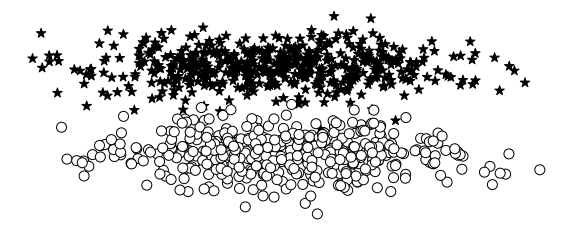

In [9]:
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

x_data, y_truth = get_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy()

left_x,right_x, left_colors,right_colors = [],[],[],[]

for x_i, y_true in zip(x_data,y_truth):
    color = 'black'
    if y_true == 0:
        left_x.append(x_i)
        left_colors.append(color)
    else:
        right_x.append(x_i)
        right_colors.append(color)
left_x = np.stack(left_x)    
right_x = np.stack(right_x)    

_, ax = plt.subplots(1,1,figsize = (10,4))
ax.scatter(left_x[:,0],left_x[:,1], color= left_colors,marker = '*', s=100)
ax.scatter(right_x[:,0],right_x[:,1], facecolor='white', edgecolor= right_colors,marker = 'o', s=100)
plt.axis('off')
plt.show()

# 훈련과정 시각화(퍼셉트론)

In [10]:
# help(optim.Adam)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


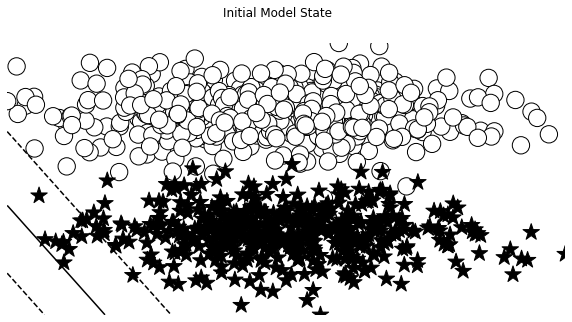

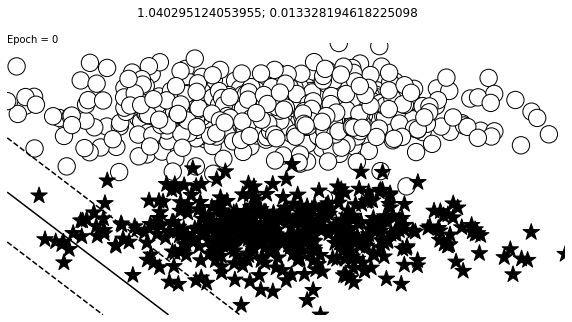

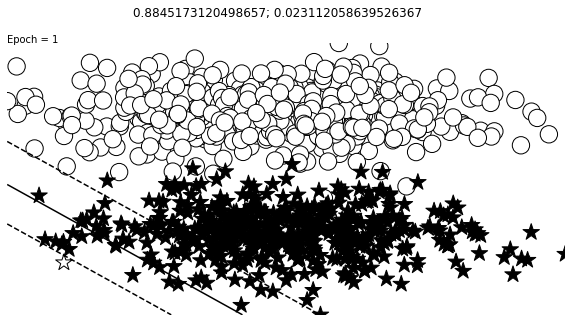

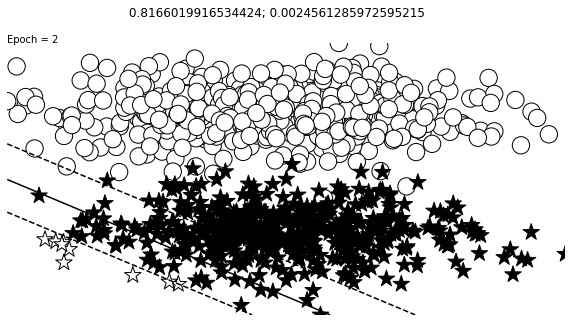

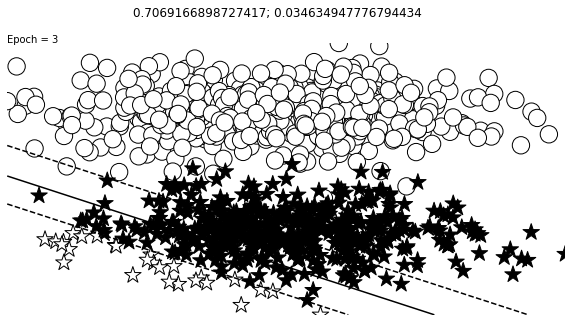

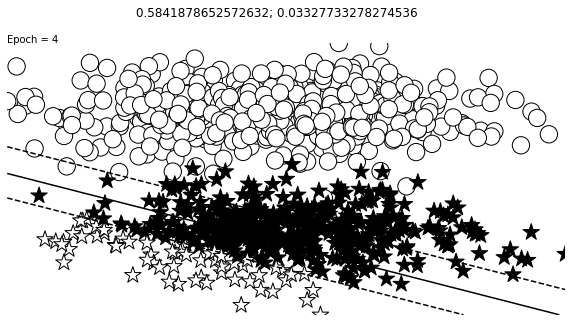

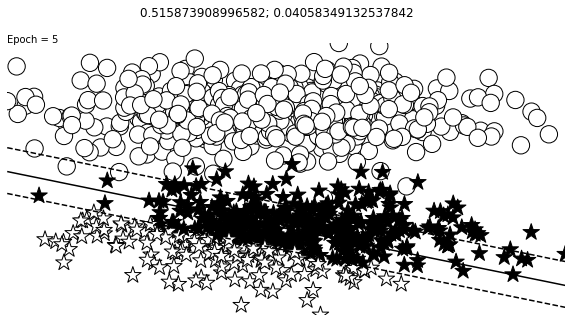

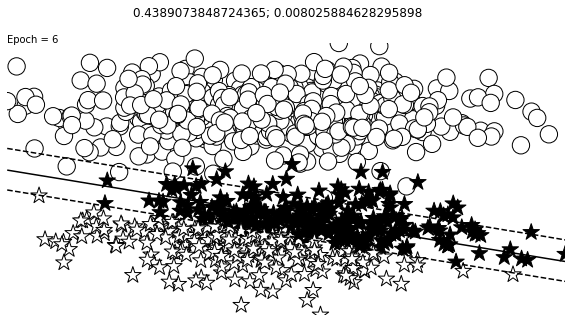

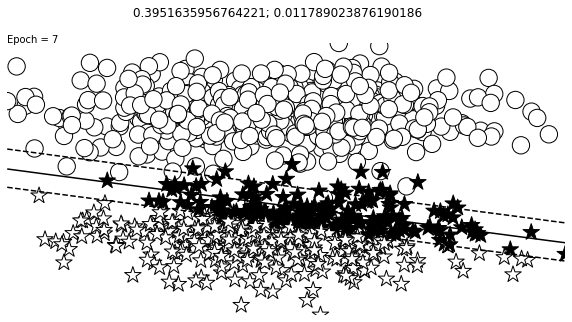

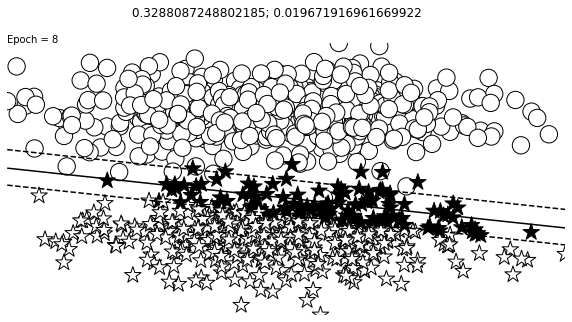

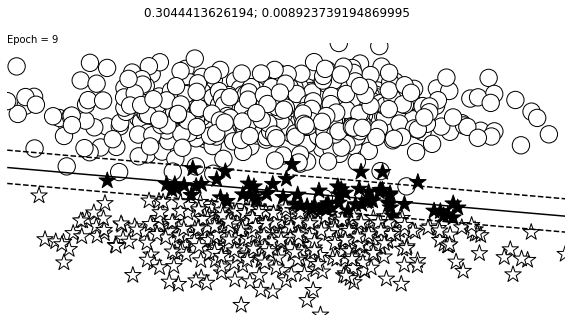

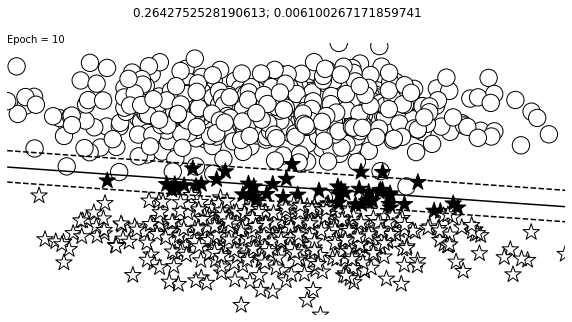

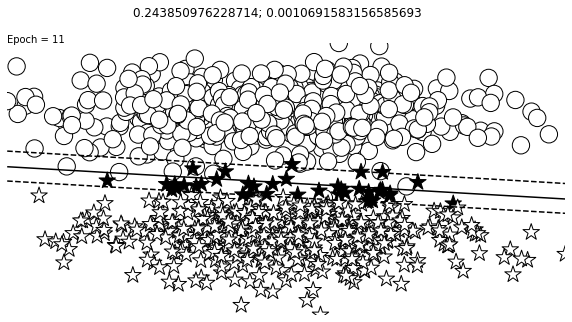

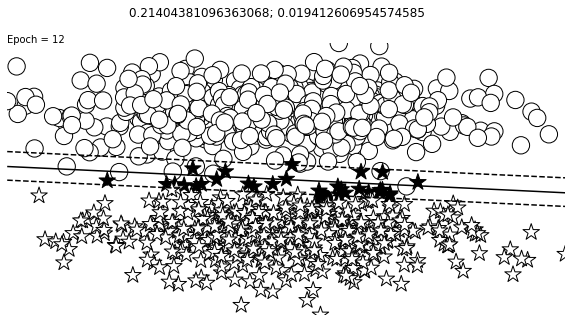

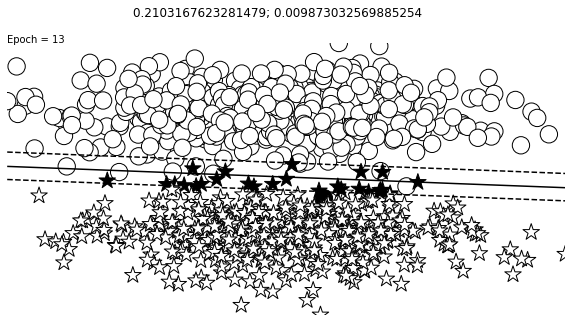

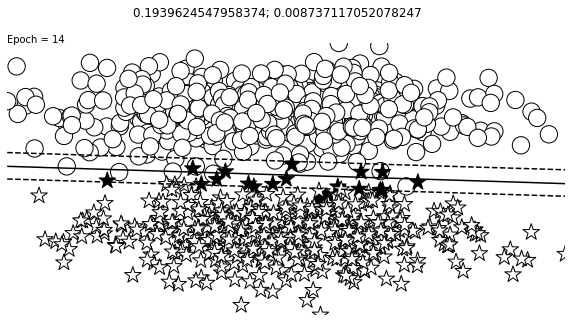

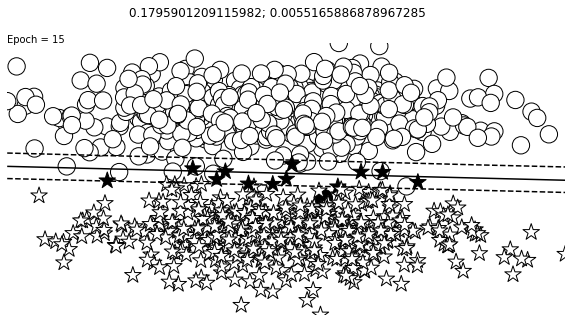

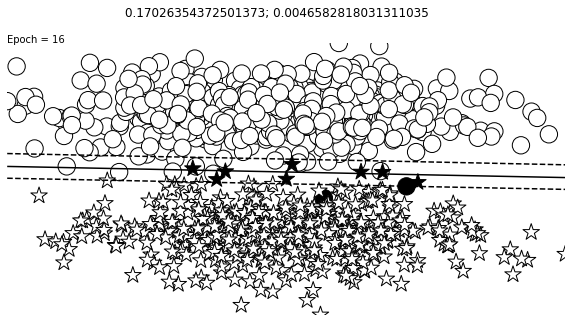

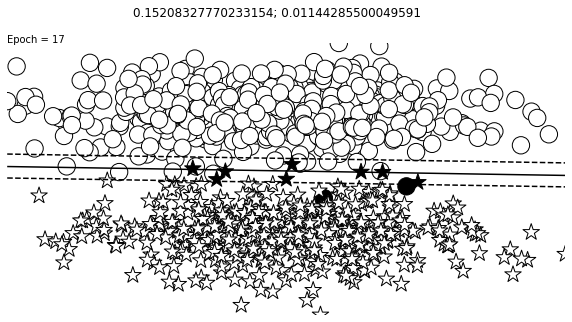

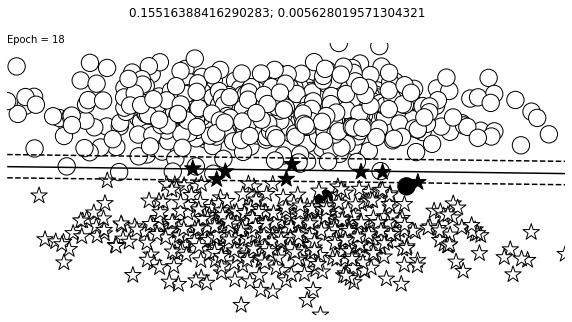

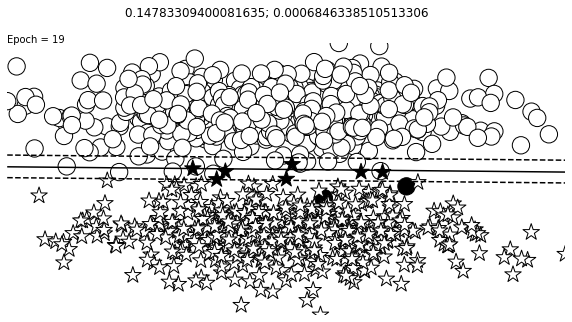

In [11]:
lr = 0.01
input_dim = 2
batch_size = 1000
n_epochs = 12
n_batches = 5

seed = 1234

torch.manual_seed(seed)
np.random.seed(seed)

perceptron =  Perceptron(input_dim = input_dim)
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = nn.BCELoss()  # 클래스가 이진일때 사용 


losses = []

x_data_static, y_truth_static =  get_data(batch_size)
fig, ax = plt.subplots(1,1,figsize=(10,5))
visualize_result(perceptron,x_data_static,y_truth_static,ax=ax,title='Initial Model State')
plt.axis('off')

change = 1.0
last = 10.0
epsilon = 1e-3  # 0.001
epoch = 0

while change > epsilon or epoch < n_epochs or last > 0.3:
    for _ in range(n_batches):
        optimizer.zero_grad();
        x_data,y_target = get_data(batch_size)
        y_pred = perceptron(x_data).squeeze()
        loss = bce_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        losses.append(loss_value)
        
        change = abs(last-loss_value)
        last = loss_value
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    visualize_result(perceptron,x_data_static,y_truth_static, ax=ax, epoch=epoch, title = f"{loss_value}; {change}")
    plt.axis('off')
    epoch += 1